In [2]:
#Librerias necesarias para trabajar con los datos
import numpy as np 
import matplotlib.pyplot as plt 
import copy

#Libreria para generar las estadisticas de curvas y escenarios de interes
from curvestat import CurveBoxPlot
from curvestat import LoadRisk

In [3]:
#Se cargan los datos generados en la investigacion de Dinamarca

#Se cargan puntos de datos iniciales (en dias) con los que se generaron las curvas
Hdata = np.load('test_data/datapoints_compartmental_simulation.npy',allow_pickle='TRUE').item()
data_time = np.arange(0,len(Hdata['data-H']),1)

#Se cargan las curvas simuladas con los datos
dic_solutions = np.load('test_data/curves_compartmental_simulation.npy',allow_pickle='TRUE').item()

# Se extraen los valores de las curvas obtenidos despues del ultimo dia de datos
dic_solutions_future = {}
last_day_of_data = 110
for curve in dic_solutions.keys() :
    dic_solutions_future[curve] = copy.copy(dic_solutions[curve][last_day_of_data:])

# Se hace un arreglo con intervalos de tiempo (en dias)
time_arr = np.arange(0,len(dic_solutions_future[0]),1)+last_day_of_data

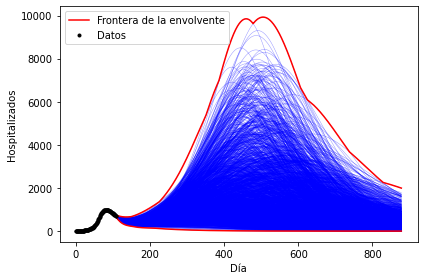

In [16]:
#Conjunto de curvas y envolvente

#Se grafica curva por curva para visualizar el conjunto de curvas
fig,ax = plt.subplots()

for i in range(len(dic_solutions_future.keys())):
    ax.plot(time_arr,dic_solutions_future[i],linewidth=0.5 , color='blue', alpha=0.4)
    
#Se encuentra el valor minimo y maximo del conjunto de curvas por cada dia para ayudar a visualizar la envolvente
min_values=[]
max_values=[]
for j in range(len(time_arr)):
    val_min=10000
    val_max=0
    for i in range(len(dic_solutions_future.keys())):
        if dic_solutions_future[i][j]<=val_min:
            val_min=dic_solutions_future[i][j]
        if dic_solutions_future[i][j]>=val_max:
            val_max=dic_solutions_future[i][j]
    min_values.append(val_min)
    max_values.append(val_max)
    
#Se grafica la envolvente
ax.plot(time_arr,min_values, color='r', label='Frontera de la envolvente')
ax.plot(time_arr,max_values, color='r')

#Se grafica el conjunto de datos con los que se generaron las simulaciones    
ax.plot(data_time,Hdata['data-H'],'k.',label='Datos')
#Se agregan leyendas y etiquetas a la grafica
plt.legend(loc=0, frameon=True)
ax.set_xlabel("Día")
ax.set_ylabel("Hospitalizados")
plt.tight_layout()
plt.savefig('Img/conjunto_de_curvas_envolvente.png',dpi=400)

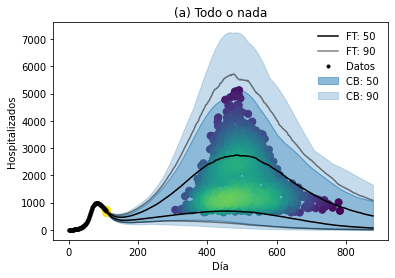

In [27]:
#Todo o nada

#Se define el diagrama de cajas, el numero de curvas por muestra (en este caso 50) 
#y el numero de repeticiones del experimento (en este caso 100)
Boxplot = CurveBoxPlot(curves=dic_solutions_future,sample_curves=50,sample_repititions=100,time=time_arr)

#Se determina el tipo de clasificacion como "todo o nada"
rank_allornothing=Boxplot.rank_allornothing()

#Generamos la envolvente basada en este tipo de clasificacion con percentiles entre el 50 y el 90
boundaries = Boxplot.get_boundaries(rank_allornothing,percentiles=[50,90])


#Generación de un mapa de calor para los extremos de algunas curvas

#Aqui, definimos a cuales curvas queremos generar el mapa de calor 
#(en este caso lo queremos generar para las curvas por debajo del percentil 50)
heatmapcurves = list(boundaries['curve-based'][50]['curves'])
#Generamos el mapa de calor con las curvas listadas de arriba 
heatmap_50 = Boxplot.get_peakheatmap(heatmap_curves=heatmapcurves)

#Se grafican la envolvente, los intervalos de centralidad de las curvas, junto con los resultados por medio de 
#estadisticas de tiempo fijo
Boxplot.plot_everything()

plt.plot(data_time,Hdata['data-H'],'k.',label='Datos')
#Se agregan leyendas y etiquetas a la grafica
plt.legend(loc=1,frameon=False)
plt.xlabel("Día")
plt.ylabel("Hospitalizados")
plt.title('(a) Todo o nada')
plt.savefig('Img/todo_o_nada.png',dpi=400)

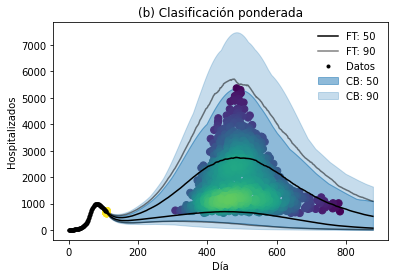

In [28]:
#Clasificacion ponderada

#Se define un vector de pesos de la función dependiente del tiempo como un decrecimiento exponencial cada 7 dias
def exp_decaying(time_vec,halftime) :
    time_vec = np.array(time_vec)
    return np.exp(-(time_vec-time_vec[0])*np.log(2)/halftime)

halftime = 7 
weights = exp_decaying(time_arr,halftime)


#Se define el diagrama de cajas como en el ejemplo de "todo o nada" 
#Se pasa el vector de pesos de la funcion dependiente del tiempo calculado antes
Boxplot_ExpDecay = CurveBoxPlot(curves=dic_solutions_future,sample_curves=50,sample_repititions=100,time_weights=weights,time=time_arr)

#Se escoge el tipo de clasificacion como un todo o nada con decrecimiento exponencial (clasificacion ponderada)
rank_ExpDecay=Boxplot_ExpDecay.rank_allornothing()

#Se genera la envolvente con percentiles 50 y 90
boundaries_ExpDecay = Boxplot_ExpDecay.get_boundaries(rank_ExpDecay,percentiles=[50,90])

#Generamos un mapa de calor para los extremos de las curvas por debajo del percentil 50
heatmapcurves_ExpDecay = list(boundaries_ExpDecay['curve-based'][50]['curves'])
heatmap_50_ExpDecay = Boxplot_ExpDecay.get_peakheatmap(heatmap_curves=heatmapcurves_ExpDecay)

#Se grafican los resultados
Boxplot_ExpDecay.plot_everything()

plt.plot(data_time,Hdata['data-H'],'k.',label='Datos')

#Se agregan leyendas y etiquetas a la grafica
plt.legend(loc=1,frameon=False)
plt.xlabel("Día")
plt.ylabel("Hospitalizados")
plt.title('(b) Clasificación ponderada')
plt.savefig('Img/clasificacion_ponderada.png',dpi=400)

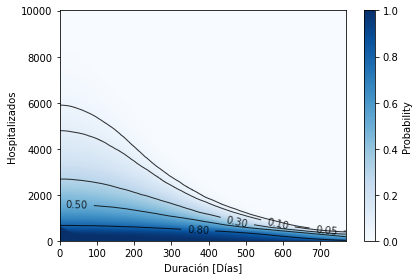

In [61]:
#Genera las probabilidades con el conjunto de curvas
LR = LoadRisk(curves=dic_solutions_future,verbose = True)

#Genera la matriz de resultados como un mapa de color
load_and_duration = LR.get_loadandduration()

#Se grafican los resultados obtenidos
LR.plot_everything()

#Se agregan leyendas y etiquetas a la grafica
plt.xlabel('Duración [Días]')
plt.ylabel('Hospitalizados')
plt.tight_layout()
plt.savefig('Img/escenarios_interes.png',dpi=400)